In [1]:
%who

Interactive namespace is empty.


In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers = 4) #threads_per_worker = 1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 22.46 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37329,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 22.46 GiB
Comm: tcp://10.0.128.141:34683,Total threads: 2
Dashboard: /proxy/34919/status,Memory: 5.62 GiB
Nanny: tcp://127.0.0.1:44441,


In [4]:
# import sys
# new_path = '/home/566/ad9701/drought_probability/'
# if new_path not in sys.path:
#     sys.path.append(new_path)

import xarray as xr
import numpy as np
import pandas as pd
#import my_glmfit_funcs as my
import climtas.io
import statsmodels.formula.api as smf

# define a function to fit a one predictor linear regression model
def fit_lm_1Pred(y, x, dryInd, predictand, predictor):
    if sum(dryInd) < 4:
        lm_params = np.array([np.nan, np.nan])
        lm_pvalues = np.array([np.nan, np.nan])
        lm_rsq_adj = np.nan
    else:
        xy_dict = {predictand:y[dryInd], predictor:x[dryInd]}
        xy_df = pd.DataFrame(xy_dict)
        formula = predictand + ' ~ ' + predictor
        lm = smf.ols(formula, xy_df)
        model_lm = lm.fit()
        lm_params = model_lm.params.values
        lm_pvalues = model_lm.pvalues.values
        lm_rsq_adj = model_lm.rsquared_adj
    return lm_params, lm_pvalues, lm_rsq_adj

projdir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'

timescale = [6, 8] #,2, 12] 

fname_sm_init = 'sm_init_*_SEA_*.nc'
fname_sm_diff = 'sm_diff_*_SEA_*.nc'
fname_PmEQ = 'PminusEQ_*_SEA_*.nc'

sm_thresh_perc = 0.3     # this is the thershold percentile to identify dry soil moisture conditions
ds_sm_perc = xr.open_dataset(projdir + 'sm_refPeriod_perc/sm_191101_to_202005_perc.nc')
da_sm_thresh = ds_sm_perc['sm'].sel(quantile = sm_thresh_perc)
# day of year is not properly assigned in the dataset of percentiles; reassigning
dayofyear = np.arange(366) + 1
da_sm_thresh = da_sm_thresh.assign_coords(dayofyear = dayofyear)

for ts in timescale:
    
    # read data
    data_dir_PmEQ = projdir + 'PminusEQ_week'+str(ts)+'/'
    ds_PmEQ = xr.open_mfdataset(data_dir_PmEQ + fname_PmEQ, chunks = {'lat':200, 'lon':100}) 
    
    data_dir_sm = projdir + 'sm_week'+str(ts)+'/'
    ds_sm_init = xr.open_mfdataset(data_dir_sm + fname_sm_init, chunks = {'lat':200, 'lon':100})
    ds_sm_diff = xr.open_mfdataset(data_dir_sm + fname_sm_diff, chunks = {'lat':200, 'lon':100})
    
    # get the corresponding thershold for each day in the init sm dataset
    da_sm_init_thresh = da_sm_thresh.sel(dayofyear = ds_sm_init['time.dayofyear'])
    
    da_PmEQ = ds_PmEQ['PminusEQ'].assign_coords(time = ds_sm_init.time).reindex(lat=ds_PmEQ.lat[::-1]).chunk(chunks = {'time':-1})   # reassigning the time & lat dimension of PmEQ to match sm exactly
    da_sm_init = ds_sm_init['sm'].chunk(chunks = {'time':-1})                                                                        # time should not be chunked becasue its the core dimension of input into ufunc
    da_sm_diff = ds_sm_diff['sm_diff'].chunk(chunks = {'time':-1})
    
    # index of dry initial soil mositure days & positive changes in delta soil moisture
    da_dryInd = ((da_sm_init<=da_sm_init_thresh) & (da_sm_diff>0)).reset_coords(['quantile','dayofyear'], drop=True)
    
    # apply the ufunc to fit logistic regression
    dask_gufunc_kwargs = {'output_sizes':{"parameter": 2}}
    kwargs = {'predictand': 'delSM', 'predictor':'PmEQ'}
    da_lmReg = xr.apply_ufunc(
        fit_lm_1Pred,                      # first the function, this function returns a tuple (params, pvalues, adjusted rsquared)
        da_sm_diff,                           # function arg
        da_PmEQ,                              #      "
        da_dryInd,                            # function arg
        kwargs = kwargs,                      #      "
        input_core_dims=[["time"], ["time"], ["time"]],   # list with one entry per arg, these are the dimensions not to be broadcast
        output_core_dims=[["parameter"], ["parameter"], []],      # dimensions of the output
        vectorize=True,                                           # broadcast over non-core dimensions of the input object?
        dask="parallelized",                                      # enable dask?
        dask_gufunc_kwargs=dask_gufunc_kwargs,                     
        output_dtypes=[float, float, float]
    )
    
    # assign co-ordinates add metadata and store in a dataset
    new_coords_dict = {'parameter':['Intercept', 'PmEQ']}
    ds_all = da_lmReg[0].rename('lm_params').assign_coords(new_coords_dict).to_dataset()
    ds_all['lm_pvalues'] = da_lmReg[1].assign_coords(new_coords_dict)
    ds_all['r-squared'] = da_lmReg[2]

    # save file
    out_file = data_dir_sm + 'sm_PmEQ_lm_results.nc'
    # ds_all.to_netcdf(out_file)
    climtas.io.to_netcdf_throttled(ds_all, out_file)
    del ds_all, da_lmReg, da_sm_diff, da_sm_init, da_dryInd, da_sm_init_thresh, ds_sm_diff, ds_sm_init, ds_PmEQ
    
# cluster.scale(cores=0)    

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [33]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 11.23 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40959,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: 23 minutes ago,Total memory: 11.23 GiB
Comm: tcp://10.0.128.153:46655,Total threads: 1
Dashboard: /proxy/42679/status,Memory: 2.81 GiB
Nanny: tcp://127.0.0.1:45601,


In [32]:
cluster.scale(cores = 4)

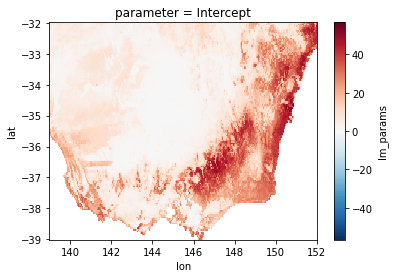

In [10]:
ds_out = xr.open_dataset(out_file)
ds_out['lm_params'][:,:,0].plot()

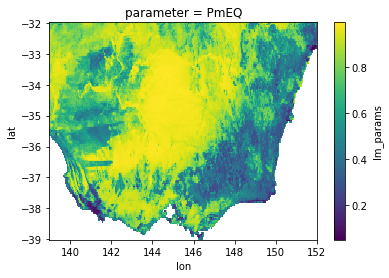

In [14]:
ds_out['lm_params'][:,:,1].plot()

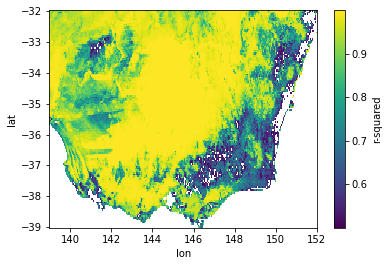

In [25]:
ds_out['r-squared'].where(ds_out['r-squared']>0.5).plot()

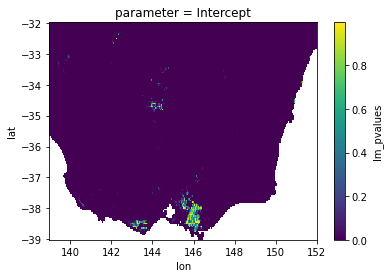

In [28]:
ds_out['lm_pvalues'][:,:,0].plot() #.where(ds_out['lm_pvalues'][:,:,1]<0.05).plot()

In [12]:
ds_all['lm_pvalues']

<xarray.DataArray 'lm_pvalues' (lat: 141, lon: 261, parameter: 2)>
dask.array<transpose, shape=(141, 261, 2), dtype=float64, chunksize=(141, 100, 2), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 -32.0 -32.05 -32.1 -32.15 ... -38.9 -38.95 -39.0
  * lon        (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 151.9 152.0
  * parameter  (parameter) <U9 'Intercept' 'PmEQ'